In [1]:
import mesa
import numpy as np
import random
from matplotlib import pyplot as plt

In [2]:
class Camino(mesa.Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.vecinos = []
    
    def agregarVecinos(self, binario):

        x = self.pos[0]
        y = self.pos[1]

        vecindario = [(x-1,y), (x,y-1), (x,y+1), (x+1,y)]
        vecinos = []

        binario = str(bin(int(binario,16))[2:].zfill(4))

        for i in range(len(binario)):
            if binario[i] == "1":
                vecinos.append(vecindario[i])
        self.vecinos = vecinos

class Estacionamiento(mesa.Agent):
    def __init__(self, unique_id, model, tipo):
        super().__init__(unique_id, model)
        self.tipo = tipo

class Banqueta(mesa.Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.tipo = 0

class Casa(mesa.Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.residentes = []
    
    def step(self):
        vecinos = self.model.grid.get_neighbors(self.pos, False)
        sigPos = 0
        for vecino in vecinos:
            if isinstance(vecino, Banqueta):
                sigPos = vecino.pos
        if sigPos != 0:
            if len(self.residentes) > 0:
                sigResidente = random.randint(0, len(self.residentes)-1)
                residente = self.residentes.pop(sigResidente)
                residente.enCasa = False
        
class Obstaculo(mesa.Agent):
    def __init__(self, unique_id, model, tipo):
        super().__init__(unique_id, model)
        self.tipo = tipo

class Semaforo(mesa.Agent):
    def __init__(self, unique_id, model, tiempoDeCambio, idSemaforo):
        super().__init__(unique_id, model)
        self.color = "green"
        self.contador = 0
        self.tiempoDeCambio = tiempoDeCambio
        self.idSemaforo = idSemaforo
    
    def step(self):
        self.contador += 1
        if self.contador%self.tiempoDeCambio == 0:
            if self.color == "red":
                self.color = "green"
            else:
                self.color = "red"
            self.contador = 0
        self.model.movimientosSemaforos.append((self.idSemaforo, self.pos[0], self.pos[1], self.color))

In [3]:
class Persona(mesa.Agent):
    def __init__(self, unique_id, model, idPersona, prob):
        super().__init__(unique_id, model)
        self.destino = ()
        self.destinoFinal = ()
        self.ruta = []
        self.auto = 0
        self.posBus = 0
        self.contador = 0
        self.idPersona = idPersona
        self.enCasa = True
        self.tipoDeTransporte = "auto"
        r = random.randint(1,100)
        p = prob
        if r <= p:
            self.tipoDeTransporte = "autobus"
        self.buscandoTransporte = True
        self.rutaEncontrada = False
        self.caminando = False

    def encontrarTransporteCercano(self, tipo):
        visitados = [[0 for x in range(self.model.ancho)] for y in range(self.model.alto)]
        abiertas = []
        abiertas.append(self.pos)
        visitados[self.pos[0]][self.pos[1]] = 1

        while len(abiertas) > 0:

            pos = abiertas.pop(0)
            
            vecinos = []
            vecindario = self.model.grid.get_neighbors(pos, False)
            for vecino in vecindario:
                if isinstance(vecino, Banqueta) or isinstance(vecino, Auto) or isinstance(vecino, Autobus):
                    vecinos.append(vecino.pos)
            
            for vecino in vecinos:
                if 0 <= vecino[0] < self.model.ancho and 0 <= vecino[1] < self.model.alto:
                    if visitados[vecino[0]][vecino[1]] == 0:
                        visitados[vecino[0]][vecino[1]] = 1
                        vecindario = self.model.grid.get_neighbors(vecino, False)
                        for vec in vecindario:
                            if tipo == "auto":
                                if isinstance(vec, Auto):
                                    if vec.dueño == 0:
                                        vec.dueño = 1
                                        self.auto = vec
                                        return 1
                            if tipo == "autobus":
                                if isinstance(vec, Autobus):
                                    self.auto = vec
                                    self.posBus = vec.pos
                                    return 1
                        abiertas.append(vecino)
                                           
    def distanciaManhattan(self, pos1, pos2):
        x1 = pos1[0]
        x2 = pos2[0]
        dx = x1 - x2

        y1 = pos1[1]
        y2 = pos2[1]
        dy = y1 - y2

        return abs(dx) + abs(dy)

    def encontrarRuta(self, inicio, final):
        dist = [[float('inf') for x in range(self.model.ancho)] for y in range(self.model.alto)]
        ruta = [[() for x in range(self.model.ancho)] for y in range(self.model.alto)]

        def reconstruirRuta():
            camino = []
            camino.append(final)
            pos = ruta[final[0]][final[1]]
            while pos != inicio:
                camino.append(pos)
                pos = ruta[pos[0]][pos[1]]
            return list(reversed(camino))

        abiertas = []
        abiertas.append(inicio)
        ruta[inicio[0]][inicio[1]] = inicio
        dist[inicio[0]][inicio[1]] = 0

        while len(abiertas) > 0:

            p = 0
            pos = abiertas.pop(p)
            
            vecinos = []
            vecindario = self.model.grid.get_neighbors(pos, False)
            for vecino in vecindario:
                if isinstance(vecino, Banqueta) or isinstance(vecino, Auto) or isinstance(vecino, Autobus):
                    vecinos.append(vecino.pos)
            
            for vecino in vecinos:
                if 0 <= vecino[0] < self.model.ancho and 0 <= vecino[1] < self.model.alto:
                    d = self.distanciaManhattan(vecino, pos) + dist[pos[0]][pos[1]]
                    if d < dist[vecino[0]][vecino[1]]:
                        dist[vecino[0]][vecino[1]] = d
                        ruta[vecino[0]][vecino[1]] = pos
                        if vecino == final:
                            abiertas = []
                        abiertas.append(vecino)

        if ruta[final[0]][final[1]] != ():
            r = reconstruirRuta()
            return r
        return 0
    
    def sigMovimiento(self):
        if len(self.ruta) > 0:
            sigPos = self.ruta.pop(0)
            self.model.grid.move_agent(self, sigPos)

    def mejorParada(self):
        distancias = []
        for parada in self.auto.paradas:
            distancias.append(self.distanciaManhattan(self.destinoFinal, parada))
        
        dic = dict(zip(self.auto.paradas, distancias))
        return(sorted(dic.items(), key=lambda item: item[1])[0][0])
      
    def step(self):
        if self.pos == self.destinoFinal:
            self.model.grid.remove_agent(self)
            self.model.schedule.remove(self)
            self.model.numPersonas -= 1
            return

        if self.enCasa:
            return

        self.contador += 1
        if self.buscandoTransporte and self.auto != 0 and self.pos == self.auto.pos:
            self.buscandoTransporte = False
            self.auto.pasajeros.append(self)
            if self.tipoDeTransporte == "autobus":
                self.auto.listaDeBajas[self] = self.mejorParada()
            if self.tipoDeTransporte == "auto":
                self.auto.encendido = True
                self.auto.destino = self.destinoFinal
                pos = self.auto.encontrarEstacionamiento(self.destinoFinal)
                self.auto.destino = pos
                self.auto.ruta = self.auto.encontrarRuta(self.pos, pos)
            
        if self.buscandoTransporte and not self.rutaEncontrada:
            self.encontrarTransporteCercano(self.tipoDeTransporte)
            ruta = 0
            if self.auto != 0 and self.tipoDeTransporte == "auto":
                ruta = self.encontrarRuta(self.pos, self.auto.pos)
            elif self.posBus != 0 and self.tipoDeTransporte == "autobus":
                ruta = self.encontrarRuta(self.pos, self.posBus)
            if ruta != 0:
                self.ruta = ruta
                self.rutaEncontrada = True
            else:
                self.caminando = True

        if self.caminando and not self.rutaEncontrada:
            ruta = self.encontrarRuta(self.pos, self.destinoFinal)
            if ruta != 0:
                self.ruta = ruta
            self.rutaEncontrada = True

        if self.contador == 5:

            noParar = True

            if len(self.ruta) > 0:
                celda = self.model.grid.get_cell_list_contents([(self.ruta[0])])
                for agente in celda:
                    if isinstance(agente, Semaforo):
                        if agente.color == "green":
                            noParar = False

            if noParar:
            
                if self.caminando and self.rutaEncontrada:
                    self.sigMovimiento()
    
                if self.buscandoTransporte and self.rutaEncontrada:
                    sigueAhiElTransporte = True
    
                    if self.tipoDeTransporte == "autobus":
                        if len(self.ruta) == 1:
                            celda = self.model.grid.get_cell_list_contents([self.ruta[0]])
                            esta = False
                            for agente in celda:
                                if isinstance(agente, Autobus):
                                    if agente == self.auto:
                                        esta = True
                            sigueAhiElTransporte = esta
    
                    if sigueAhiElTransporte:
                        self.sigMovimiento()
            
            self.contador = 0

        self.model.movimientosPersonas.append((self.idPersona, self.pos[0], self.pos[1], "0"))

In [4]:
class Auto(mesa.Agent):
    def __init__(self, unique_id, model, idAuto):
        super().__init__(unique_id, model) 
        self.inicio = 0
        self.destino = 0
        self.ruta = 0
        self.dueño = 0
        self.idAuto = idAuto
        self.desesperacion = 0
        self.pasajeros = []
        self.encendido = False

    def encontrarEstacionamiento(self, inicio):
        visitados = [[0 for x in range(self.model.ancho)] for y in range(self.model.alto)]

        abiertas = []
        abiertas.append(inicio)
        visitados[inicio[0]][inicio[1]] = 1


        while len(abiertas) > 0:
            
            p = 0
            pos = abiertas.pop(p)

            x = pos[0]
            y = pos[1]

            vecinos = [(x+1,y),(x-1,y),(x,y+1),(x,y-1)]

            for vecino in vecinos:
                if 0 <= vecino[0] < self.model.ancho and 0 <= vecino[1] < self.model.alto:
                    if visitados[vecino[0]][vecino[1]] == 0:
                        visitados[vecino[0]][vecino[1]] = 1
                        vecindario = self.model.grid.get_neighbors(vecino, False)
                        for vec in vecindario:
                            if isinstance(vec, Estacionamiento):
                                if vec.tipo == 1 and not self.estaOcupada(vec.pos):
                                    return vec.pos
                        abiertas.append(vecino)
        return 0  

    def distanciaManhattan(self, pos1, pos2):
        x1 = pos1[0]
        x2 = pos2[0]
        dx = x1 - x2

        y1 = pos1[1]
        y2 = pos2[1]
        dy = y1 - y2

        return abs(dx) + abs(dy)
    
    def encontrarRuta(self, inicio, final):

        dist = [[float('inf') for x in range(self.model.ancho)] for y in range(self.model.alto)]
        ruta = [[() for x in range(self.model.ancho)] for y in range(self.model.alto)]

        def reconstruirRuta():
            camino = []
            camino.append(final)
            pos = ruta[final[0]][final[1]]
            while pos != inicio:
                camino.append(pos)
                pos = ruta[pos[0]][pos[1]]
            return list(reversed(camino))

        abiertas = []
        abiertas.append(inicio)
        ruta[inicio[0]][inicio[1]] = inicio
        dist[inicio[0]][inicio[1]] = 0

        while len(abiertas) > 0:
            
            p = 0
            valorMin = float('inf')
            for i in range(len(abiertas)):
                valor = dist[abiertas[i][0]][abiertas[i][1]]
                if valor < valorMin:
                    valorMin = valor
                    p = i

            pos = abiertas.pop(p)
            
            vecinos = []
            celda = self.model.grid.get_cell_list_contents([pos])
            for agente in celda:
                if isinstance(agente, Camino):
                    vecinos = agente.vecinos
            
            for vecino in vecinos:
                if 0 <= vecino[0] < self.model.ancho and 0 <= vecino[1] < self.model.alto:
                    d = self.distanciaManhattan(vecino, pos) + dist[pos[0]][pos[1]]
                    if d < dist[vecino[0]][vecino[1]]:
                        dist[vecino[0]][vecino[1]] = d
                        ruta[vecino[0]][vecino[1]] = pos
                        abiertas.append(vecino)  

        if ruta[final[0]][final[1]] != ():
            r = reconstruirRuta()
            return r
        return 0

    def validarPosicion(self,pos):
        x = pos[0]
        y = pos[1]
        noSalir = 0 <= x < self.model.ancho and 0 <= y < self.model.alto
        noChocar = True
        if noSalir:
            celda = self.model.grid.get_cell_list_contents([(x,y)])
            for agente in celda:
                if not isinstance(agente, Camino) and not isinstance(agente, Estacionamiento) and not isinstance(agente, Banqueta) and not isinstance(agente, Semaforo):
                    noChocar = False
                if isinstance(agente, Auto) or isinstance(agente, Autobus) or isinstance(agente, Persona):
                    noChocar = False
        return noSalir and noChocar
    
    def estaOcupada(self, pos):
        ocupada = False
        celda = self.model.grid.get_cell_list_contents([pos])
        for agente in celda:
            if not isinstance(agente, Camino) and not isinstance(agente, Estacionamiento) and not isinstance(agente, Banqueta):
                ocupada = True
        return ocupada

    def sigMovimiento(self):


        if self.ruta != 0:
            if len(self.ruta) > 0:
                sigPos = self.ruta[0]

                if self.estaOcupada(sigPos):
                    if len(self.ruta) == 1:
                        nuevoDestino = self.encontrarEstacionamiento(self.destino)
                        if nuevoDestino != 0:
                            self.destino = nuevoDestino
                            self.ruta = self.encontrarRuta(self.pos, nuevoDestino)
                        else:
                            self.destino = self.inicio
                            self.ruta = self.encontrarRuta(self.pos, self.inicio)
                    elif self.desesperacion == 25:
                        self.desesperacion = 0
                        vecinosValidos = []
                        celda = self.model.grid.get_cell_list_contents([self.pos])
                        for agente in celda:
                            if isinstance(agente, Camino):
                                for vecino in agente.vecinos:
                                    if self.validarPosicion(vecino):
                                        vecinosValidos.append(vecino)
                        if len(vecinosValidos) > 0:
                            pos = random.choice(vecinosValidos)
                            ruta = self.encontrarRuta(pos, self.destino)
                            if ruta != 0:
                                self.ruta = ruta
                                self.model.grid.move_agent(self, pos)
                                for pasajero in self.pasajeros:
                                    self.model.grid.move_agent(pasajero, pos)
                                return

                choque = False
                celda = self.model.grid.get_cell_list_contents([sigPos])
                for agente in celda:
                    if isinstance(agente, Auto) or isinstance(agente, Autobus) or isinstance(agente, Persona):
                        choque = True

                if self.validarPosicion(sigPos) and not choque:
                    pos = self.ruta.pop(0)
                    self.model.grid.move_agent(self, pos)
                    for pasajero in self.pasajeros:
                        self.model.grid.move_agent(pasajero, pos)
                else:
                    self.desesperacion += 1

    def step(self):
        if self.inicio == 0:
            self.inicio = self.pos

        if self.pos == self.destino and self.encendido:
            vecinos = self.model.grid.get_neighbors(self.pos, False)
            sigPos = 0
            for vecino in vecinos:
                if isinstance(vecino, Banqueta):
                    sigPos = vecino.pos
            if sigPos != 0:
                if len(self.pasajeros) > 0:
                    sigPasajero = random.randint(0, len(self.pasajeros)-1)
                    pasajero = self.pasajeros.pop(sigPasajero)
                    self.model.grid.move_agent(pasajero, sigPos)
                    pasajero.caminando = True
                    pasajero.rutaEncontrada = False
                else:
                    self.encendido = False

        if self.encendido:
            noParar = True
            if self.ruta != 0:
                if len(self.ruta) > 0:
                    celda = self.model.grid.get_cell_list_contents([(self.ruta[0])])
                    for agente in celda:
                        if isinstance(agente, Semaforo):
                            if agente.color == "red":
                                noParar = False
                            else:
                                noParar = True
                
            if noParar:
                self.sigMovimiento()
                self.model.contaminacion += 1


        self.model.movimientosAutos.append((self.idAuto, self.pos[0], self.pos[1], "0"))

In [5]:
class Autobus(mesa.Agent):
    def __init__(self, unique_id, model, paradas, idBus):
        super().__init__(unique_id, model) 
        self.paradas = paradas
        self.siguienteParada = ()
        self.listaDeBajas = {}
        self.capacidad = 20
        self.tiempoDeSalida = 75
        self.ruta = ()
        self.pasajeros = []
        self.contador = 0
        self.encendido = False
        self.idBus = idBus

    def distanciaManhattan(self, pos1, pos2):
        x1 = pos1[0]
        x2 = pos2[0]
        dx = x1 - x2

        y1 = pos1[1]
        y2 = pos2[1]
        dy = y1 - y2

        return abs(dx) + abs(dy)

    def ordenarParadas(self):
        distancias = []
        for parada in self.paradas:
            distancias.append(self.distanciaManhattan(self.pos, parada))
        
        dic = dict(zip(self.paradas, distancias))
        p = list(dict(sorted(dic.items(), key=lambda item: item[1])).keys())
        self.paradas = p

    def encontrarRuta(self, inicio, final):

        dist = [[float('inf') for x in range(self.model.ancho)] for y in range(self.model.alto)]
        ruta = [[() for x in range(self.model.ancho)] for y in range(self.model.alto)]

        def reconstruirRuta():
            camino = []
            camino.append(final)
            pos = ruta[final[0]][final[1]]
            while pos != inicio:
                camino.append(pos)
                pos = ruta[pos[0]][pos[1]]
            return list(reversed(camino))

        abiertas = []
        abiertas.append(inicio)
        ruta[inicio[0]][inicio[1]] = inicio
        dist[inicio[0]][inicio[1]] = 0

        while len(abiertas) > 0:
            
            p = 0
            valorMin = float('inf')
            for i in range(len(abiertas)):
                valor = dist[abiertas[i][0]][abiertas[i][1]]
                if valor < valorMin:
                    valorMin = valor
                    p = i

            pos = abiertas.pop(p)
            
            vecinos = []
            celda = self.model.grid.get_cell_list_contents([pos])
            for agente in celda:
                if isinstance(agente, Camino):
                    vecinos = agente.vecinos
            
            for vecino in vecinos:
                if 0 <= vecino[0] < self.model.ancho and 0 <= vecino[1] < self.model.alto:
                    d = self.distanciaManhattan(vecino, pos) + dist[pos[0]][pos[1]]
                    if d < dist[vecino[0]][vecino[1]]:
                        dist[vecino[0]][vecino[1]] = d
                        ruta[vecino[0]][vecino[1]] = pos
                        abiertas.append(vecino)  

        if ruta[final[0]][final[1]] != ():
            r = reconstruirRuta()
            return r
        return 0

    def validarPosicion(self,pos):
        x = pos[0]
        y = pos[1]
        noSalir = 0 <= x < self.model.ancho and 0 <= y < self.model.alto
        noChocar = True
        if noSalir:
            celda = self.model.grid.get_cell_list_contents([(x,y)])
            for agente in celda:
                if not isinstance(agente, Camino) and not isinstance(agente, Estacionamiento) and not isinstance (agente, Banqueta) and not isinstance(agente, Semaforo):
                    noChocar = False
        return noSalir and noChocar
    
    def sigMovimiento(self):
        if self.ruta != 0:
            if len(self.ruta) > 0:
                sigPos = self.ruta[0]
                choque = False
                celda = self.model.grid.get_cell_list_contents([sigPos])
                for agente in celda:
                    if isinstance(agente, Auto) or isinstance(agente, Autobus) or isinstance(agente, Persona):
                        choque = True
                if self.validarPosicion(sigPos) and not choque:
                    pos = self.ruta.pop(0)
                    self.model.grid.move_agent(self, pos)
                    for pasajero in self.pasajeros:
                        self.model.grid.move_agent(pasajero, pos)

    def step(self):
    
        if not self.encendido:
            self.contador += 1

        if not self.encendido and (self.capacidad == len(self.pasajeros) or self.contador == self.tiempoDeSalida):
            self.encendido = True
            self.siguienteParada = self.paradas.pop(0)
            self.paradas.append(self.siguienteParada)
            self.ruta = self.encontrarRuta(self.pos, self.siguienteParada)
            self.contador = 0

        if self.pos == self.siguienteParada:
            vecinos = self.model.grid.get_neighbors(self.pos, False)
            sigPos = 0
            for vecino in vecinos:
                if isinstance(vecino, Banqueta):
                    sigPos = vecino.pos
            if sigPos != 0:
                bajan = []
                for k, v in self.listaDeBajas.items():
                    if v == self.pos:
                        bajan.append(k)
                if len(bajan) > 0:
                    sigPasajero = random.randint(0, len(bajan)-1)
                    pasajero = bajan.pop(sigPasajero)
                    self.pasajeros.remove(pasajero)
                    self.listaDeBajas.pop(pasajero)
                    self.model.grid.move_agent(pasajero, sigPos)
                    pasajero.caminando = True
                    pasajero.rutaEncontrada = False
                else:
                    self.encendido = False

        if self.encendido:
            noParar = True
            celda = self.model.grid.get_cell_list_contents([(self.pos)])
            for agente in celda:
                if isinstance(agente, Semaforo):
                    if agente.color == "red":
                        noParar = False
                
            if noParar:
                self.sigMovimiento()
                self.model.contaminacion += 2

        self.model.movimientosBuses.append((self.idBus, self.pos[0], self.pos[1], "0"))

In [6]:
class Ciudad(mesa.Model):
    def __init__(self, N):

        # 0 0000
        # 1 0001
        # 2 0010
        # 3 0011
        # 4 0100
        # 5 0101
        # 6 0110
        # 7 0111
        # 8 1000
        # 9 1001
        # A 1010
        # B 1011
        # C 1100
        # D 1101
        # E 1110
        # F 1111

        mapaRespaldo = [
            [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] ,
            [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] ,
            [' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' '] ,
            [' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' '] ,
            [' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' '] ,
            [' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' '] ,
            [' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' '] ,
            [' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' '] ,
            [' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' '] ,
            [' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' '] ,
            [' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' '] ,
            [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] ,
            [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] ,
            [' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' '] ,
            [' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' '] ,
            [' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' '] ,
            [' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' '] ,
            [' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' '] ,
            [' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' '] ,
            [' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' '] ,
            [' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' '] ,
            [' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' '] ,
            [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] ,
            [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] ,
            [' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' '] ,
            [' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' '] ,
            [' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' '] ,
            [' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' '] ,
            [' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' '] ,
            [' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' '] ,
            [' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' '] ,
            [' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' '] ,
            [' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' '] ,
            [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] ,
            [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] ,
            [' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' '] ,
            [' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' '] ,
            [' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' '] ,
            [' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' '] ,
            [' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' '] ,
            [' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' '] ,
            [' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' '] ,
            [' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' '] ,
            [' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' ', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', ' ', ' '] ,
            [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] ,
            [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] ,
        ]
        
        mapaSemaforos = [
            [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] ,
            [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] ,
            [' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', 'R', 'R', '|', '|', '|', '|', '|', '|', '|', '|', '|', 'V', 'V', '|', '|', '|', '|', '|', '|', '|', '|', '|', 'R', 'R', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' '] ,
            [' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' '] ,
            [' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' '] ,
            [' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' '] ,
            [' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' '] ,
            [' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' '] ,
            [' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' '] ,
            [' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' '] ,
            [' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', 'V', 'V', '|', '|', '|', '|', '|', '|', '|', '|', '|', 'R', 'R', '|', '|', '|', '|', '|', '|', '|', '|', '|', 'V', 'V', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' '] ,
            [' ', ' ', 'V', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'R', ' ', ' ', 'R', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'V', ' ', ' ', 'V', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'R', ' ', ' ', 'R', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'V', ' ', ' '] ,
            [' ', ' ', 'V', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'R', ' ', ' ', 'R', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'V', ' ', ' ', 'V', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'R', ' ', ' ', 'R', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'V', ' ', ' '] ,
            [' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', 'V', 'V', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', 'V', 'V', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' '] ,
            [' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' '] ,
            [' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' '] ,
            [' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' '] ,
            [' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' '] ,
            [' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' '] ,
            [' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' '] ,
            [' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' '] ,
            [' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', 'R', 'R', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', 'R', 'R', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' '] ,
            [' ', ' ', 'R', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'V', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'V', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] ,
            [' ', ' ', 'R', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'V', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'V', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] ,
            [' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', 'R', 'R', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', 'R', 'R', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' '] ,
            [' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' '] ,
            [' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' '] ,
            [' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' '] ,
            [' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' '] ,
            [' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' '] ,
            [' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' '] ,
            [' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' '] ,
            [' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', 'V', 'V', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', 'V', 'V', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' '] ,
            [' ', ' ', 'V', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'R', ' ', ' ', 'R', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'V', ' ', ' ', 'V', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'R', ' ', ' ', 'R', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'V', ' ', ' '] ,
            [' ', ' ', 'V', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'R', ' ', ' ', 'R', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'V', ' ', ' ', 'V', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'R', ' ', ' ', 'R', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'V', ' ', ' '] ,
            [' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', 'V', 'V', '|', '|', '|', '|', '|', '|', '|', '|', '|', 'R', 'R', '|', '|', '|', '|', '|', '|', '|', '|', '|', 'V', 'V', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' '] ,
            [' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' '] ,
            [' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' '] ,
            [' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' '] ,
            [' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' '] ,
            [' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' '] ,
            [' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' '] ,
            [' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' '] ,
            [' ', ' ', '|', '|', '|', '|', '|', '|', '|', '|', '|', 'R', 'R', '|', '|', '|', '|', '|', '|', '|', '|', '|', 'V', 'V', '|', '|', '|', '|', '|', '|', '|', '|', '|', 'R', 'R', '|', '|', '|', '|', '|', '|', '|', '|', '|', ' ', ' '] ,
            [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] ,
            [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] ,
        ]

        mapa = [
            ['F', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'F'] ,
            ['D', '5', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'EX','E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'C', 'B'] ,
            ['D', 'D', 'K', 'K', 'K', 'K', 'KD','K', 'K', 'K', 'K', 'KB','KB','K', 'P2','P2','P2','4', 'P2','P2','P2','K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'KD','KD','K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'B', 'B'] ,
            ['D', 'D', 'K', 'H', 'K', 'P1','D', 'P8','K', 'H', 'K', 'B', 'B', 'K', 'K', 'K', 'K', '4', 'K', 'K', 'K', 'K', 'T', 'T', 'K', 'O', 'O', 'O', 'K', 'O','OKZ','O', 'K', 'D', 'D', 'K', 'O', 'O', 'K', 'OKZ','K','O', 'O', 'K', 'B', 'B'] ,
            ['D', 'D', 'K', 'H', 'K', 'P1','D', 'P8','K', 'H', 'K', 'B', 'B', 'K', 'H', 'H', 'H', '4', 'H', 'H', 'H', 'K', 'T', 'T', 'K','OKZ','O', 'O', 'K', 'O', 'O', 'O', 'K', 'D', 'D', 'K', 'O', 'O', 'K', 'O', 'K', 'OKZ','O','K', 'B', 'B'] ,
            ['D', 'D', 'K', 'H', 'K', 'P1','D', 'P8','K', 'H', 'K', 'B', 'B', 'K', 'H', 'K', 'P1','4', 'P8','K', 'H', 'K', 'T', 'T', 'K', 'O', 'O', 'O', 'K', 'O', 'O', 'O', 'K', 'D', 'D', 'K', 'O', 'O', 'K', 'O', 'K', 'O', 'O', 'K', 'B', 'B'] ,
            ['D', 'D', 'K', 'H', 'K', 'P1','D', 'P8','K', 'H', 'K', 'B', 'B', 'K', 'H', 'K', 'P1','4', 'P8','K', 'H', 'K', 'T', 'T', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'D', 'D', 'K', 'O' ,'O', 'K', 'O', 'K', 'K', 'K', 'K', 'B', 'B'] ,
            ['D', 'D', 'K', 'H', 'K', 'P1','D', 'P8','K', 'H', 'K', 'B', 'B', 'K', 'H', 'K', 'P1','4', 'P8','K', 'H', 'K', 'T', 'T', 'K', 'O', 'O', 'O', 'K', 'O', 'O', 'O', 'K', 'D', 'D', 'K', 'OKZ','O','K', 'K', 'K', 'O', 'O', 'K', 'B', 'B'] ,
            ['D', 'D', 'K', 'H', 'K', 'P1','D', 'P8','K', 'H', 'K', 'B', 'B', 'K', 'H', 'K', 'P1','4', 'P8','K', 'H', 'K', 'T', 'T', 'K', 'O', 'O','OKZ','K', 'O', 'O', 'O', 'K', 'D', 'D', 'K', 'K', 'K', 'K', 'K', 'K', 'OKZ','O','K', 'B', 'B'] ,
            ['D', 'D', 'K', 'H', 'K', 'P1','D', 'P8','K', 'H', 'K', 'B', 'B', 'K', 'H', 'K', 'P1','4', 'P8','K', 'H', 'K', 'T', 'T', 'K', 'O', 'O', 'O', 'K', 'O', 'O', 'O', 'K', 'D', 'D', 'K', 'O', 'OKZ','O','O', 'K', 'O', 'O', 'K', 'B', 'B'] ,
            ['D', 'D', 'K', 'K', 'K', 'K', 'KD','K', 'K', 'K', 'K', 'KB','KB','K', 'K', 'K', 'K', '4', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'KD','KD','K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'B', 'B'] ,
            ['D', 'C' ,'K7','7', '7', '7', '7', '7X','7', '7', 'K7','B', 'B', 'K7', '7', '7', '7', '7', '7', '7', '7','K7','7', '7', 'K7','7', '7', '7', '7', '7', '7', '7', 'K7','D', 'D', 'K7','7', '7', '7', '7', '7', '7', '7', 'K7','B', 'B'] ,
            ['D', 'C', 'K7','7', '7', '7', '7', '7', '7', '7', 'K7','B', 'B', 'K7', '7', '7', '7', '7', '7', '7', '7','K7','7', '7', 'K7','7', '7', '7', '7', '7', '7', '7', 'K7','D', 'D', 'K7','7', '7', '7', '7', '7', '7', '7', 'K7','B', 'B'] ,
            ['D', 'D', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'KB','KB','K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'KD','KD','K', 'K', 'K4','K', 'K', 'K', 'K2','K', 'K', 'B', 'B'] ,
            ['D', 'D', 'K', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'K', 'B', 'B', 'K', 'Q', 'K', 'Q', 'K', 'Q', 'K', 'K', 'K', 'T', 'T', 'K', 'O', 'O', 'K', 'K', 'O', 'O', 'K', 'K', 'D', 'D', 'K', 'Q', 'F', 'Q', 'K', 'Q', 'F', 'Q', 'K', 'B', 'B'] ,
            ['D', 'D', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'B', 'B', 'K1','F', 'F', 'F', 'F', 'F', 'F', 'Q', 'K', 'T', 'T', 'K', 'O', 'O', 'K', 'K', 'O', 'O', 'O', 'K', 'D', 'D', 'K', 'K', 'F', 'F', 'F', 'F', 'F', 'K', 'K', 'B', 'B'] ,
            ['D', 'D', 'K', 'P4','P4','P4','P4','P4','P4','P4','K', 'B', 'B', 'K', 'Q', 'F', 'F', 'F', 'F', 'F', 'K', 'K', 'T', 'T', 'K', 'O', 'O', 'K', 'K', 'O', 'O', 'O', 'K', 'D', 'D', 'K', 'Q', 'F', 'F', 'F', 'F', 'F', 'Q', 'K', 'B', 'B'] ,
            ['D', 'D', 'K7','7', '7', '7', '7', '7', '7', '7', 'K7','B', 'B', 'K', 'K', 'F', 'F', 'F', 'F', 'F', 'Q', 'K', 'T', 'T', 'K', 'O','OKZ','K', 'K','OKZ','O', 'O', 'K', 'D', 'D', 'K', 'K', 'F', 'F', 'F', 'F', 'F', 'K', 'K', 'B', 'B'] ,
            ['D', 'D', 'K', 'P2','P2','P2','P2','P2','P2','P2','K', 'B', 'B', 'K', 'Q', 'F', 'F', 'F', 'F', 'F', 'K', 'K', 'T', 'T', 'K', 'O', 'O', 'K', 'K', 'O', 'O', 'O', 'K', 'D', 'D', 'K', 'Q', 'F', 'F', 'F', 'F', 'F', 'Q', 'K', 'B', 'B'] ,
            ['D', 'D', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'B', 'B', 'K8','F', 'F', 'F', 'F', 'F', 'F', 'Q', 'K', 'T', 'T', 'K', 'O', 'O', 'K', 'K', 'O', 'O', 'O', 'K', 'D', 'D', 'K', 'K', 'F', 'F', 'F', 'F', 'F', 'K', 'K', 'B', 'B'] ,
            ['D', 'D', 'K', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'K', 'B', 'B', 'K', 'Q', 'K', 'Q', 'K', 'Q', 'K', 'K', 'K', 'T', 'T', 'K', 'O', 'O', 'K', 'K', 'O', 'O', 'K', 'K', 'D', 'DY','K', 'K', 'Q', 'K', 'Q', 'K', 'Q', 'K', 'K', 'B', 'B'] ,
            ['D', 'D', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'KB','KB','K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'KD','KD','K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'B', 'B'] ,
            ['D', 'D', 'K', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'K', 'B', 'B', 'K', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'K', 'T', 'T', 'K', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'K', 'D', 'D', 'K', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'K', 'B', 'B'] ,
            ['D', 'D', 'K', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'K', 'B', 'B', 'K', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'K', 'T', 'T', 'K', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'K', 'D', 'D', 'K', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'K', 'B', 'B'] ,
            ['D', 'DX','K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'KB','KB','K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'KD','KD','K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'B', 'B'] ,
            ['D', 'D', 'K', 'H', 'K', '6', 'P8','K', '6', 'P8','K', 'B', 'B', 'K', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'K', 'T', 'T', 'K', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'K', 'D', 'D', 'K', 'O', 'O', 'O', 'K', 'O', 'O', 'O', 'K', 'B', 'B'] ,
            ['D', 'D', 'K', 'H', 'K', '6', 'P8','K', '6', 'P8','K', 'B', 'B', 'K', 'K', 'O', 'O', 'K', 'O', 'O', 'K', 'K', 'T', 'T', 'K', 'O', 'O', 'O', 'O','OKZ','O', 'O', 'K', 'D', 'D', 'K', 'O', 'O', 'O', 'K', 'O', 'OKZ','O','K', 'B', 'B'] ,
            ['D', 'D', 'K', 'H', 'K', '6', 'P8','K', '6', 'P8','K', 'B', 'B', 'K', 'O', 'O', 'K', 'K', 'K', 'O', 'O', 'K', 'T', 'T', 'K', 'O', 'O', 'K', 'K', 'K', 'K', 'K', 'K', 'D', 'D', 'K', 'O', 'O','OKZ','K', 'K', 'K', 'K', 'K', 'B', 'B'] ,
            ['D', 'D', '1', '1', '1', '1', '1', '1', '1', '1', 'K1','B', 'B', 'K', 'K', 'O', 'O', 'K', 'O', 'O', 'K', 'K', 'T', 'T', 'K', 'O', 'O', 'K', '3', '1', '1', '1', 'K1','D', 'D', 'K', 'O', 'O', 'K', 'K', 'O', 'O', 'O', 'K', 'B', 'B'] ,
            ['D', 'D', 'K', 'H', 'K', '6', 'P8','K', '6', 'P8','K', 'BX','B', 'K', 'O', 'O', 'O','OKZ','O', 'O', 'O', 'K', 'T', 'T', 'K', 'O', 'O', 'K', '2', 'K', 'K', 'K', 'K', 'D', 'D', 'K', 'K', 'K', 'K', 'O', 'O', 'O', 'O', 'K', 'B', 'B'] ,
            ['D', 'D', 'K', 'H', 'K', '6', 'P8','K', '6', 'P8','K', 'B', 'B', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'T', 'T', 'K', 'O','OKZ','K', '2', 'K', 'O', 'O', 'K', 'D', 'D', 'K', 'O', 'O', 'K', 'O', 'O', 'O', 'O', 'K', 'B', 'B'] ,
            ['D', 'D', 'K', 'H', 'K', '6', 'P8','K', '6', 'P8','K', 'B', 'B', 'K', 'O', 'O', 'O', 'K', 'O', 'O', 'O', 'K', 'T', 'T', 'K', 'O', 'O', 'K', 'K2','K', 'O', 'O', 'K', 'D', 'D', 'K', 'OKZ','O','K', 'O', 'O', 'O', 'O', 'K', 'B', 'B'] ,
            ['D', 'D', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'KB','KB','K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', '2', 'K', 'K', 'K', 'K', 'KD','KD','K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'B', 'B'] ,
            ['D', 'C', 'KE','E', 'E', 'E', 'E', 'E', 'E', 'E', 'KE','B', 'B', 'KE','E', 'E', 'E', 'E', 'E', 'E', 'E', 'KE','E', 'E', 'KE','E', 'E', 'E', 'E', 'E', 'E', 'E', 'KE','D', 'D', 'KE','E', 'E', 'E', 'E', 'E', 'E', 'E', 'KE','B', 'B'] ,
            ['D', 'C', 'KE','E', 'E', 'E', 'E', 'E', 'E', 'E', 'KE','B', 'B', 'KE','E', 'E', 'E', 'E', 'E', 'E', 'E', 'KE','E', 'E', 'KE','E', 'E', 'E', 'E', 'E', 'E', 'E', 'KE','D', 'D', 'KE','E', 'E', 'E', 'E', 'E', 'E', 'E', 'KE','B', 'B'] ,
            ['D', 'D', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'KB','KB','K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'KD','KD','K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'B', 'B'] ,
            ['D', 'D', 'K', 'K', 'K', 'O', 'O', 'O', 'O', 'O', 'K', 'B', 'B', 'K', 'K', 'Q', 'K', 'Q', 'K', 'Q', 'K', 'K', 'T', 'T', 'K', 'O', 'O', 'O', 'K', 'O', 'O', 'O', 'K', 'D', 'DY','K', 'Q', 'K', 'Q', 'K', 'Q', 'K', 'K', 'K', 'B', 'B'] ,
            ['D', 'D', 'K', 'K', 'K', 'K', 'O', 'O', 'O', 'O', 'K', 'B', 'B', 'K', 'K', 'F', 'F', 'F', 'F', 'F', 'K', 'K', 'T', 'T', 'K', 'O', 'O', 'O', 'K','OKZ','O', 'O', 'K', 'D', 'D', 'K1','F', 'F', 'F', 'F', 'F', 'F', 'Q', 'K', 'B', 'B'] ,
            ['D', 'D', 'K', 'K', 'O', 'K', 'K','OKZ','O', 'O', 'K', 'B', 'B', 'K', 'Q', 'F', 'F', 'F', 'F', 'F', 'Q', 'K', 'T', 'T', 'K', 'O', 'O', 'O', 'K', 'O', 'O', 'O', 'K', 'D', 'D', 'K', 'Q', 'F', 'F', 'F', 'F', 'F', 'K', 'K', 'B', 'B'] ,
            ['D', 'D', 'K', 'O', 'O', 'O', 'K', 'K', 'O', 'O', 'K', 'B', 'B', 'K', 'K', 'F', 'F', 'F', 'F', 'F', 'K', 'K', 'T', 'T', 'K', 'O', 'O','OKZ','K', 'K', 'K', 'K', 'K', 'D', 'D', 'K', 'K', 'F', 'F', 'F', 'F', 'F', 'Q', 'K', 'B', 'B'] ,
            ['D', 'D', 'K', 'O', 'O','OKZ','K', 'K', 'K', 'O', 'K', 'B', 'B', 'K', 'Q', 'F', 'F', 'F', 'F', 'F', 'Q', 'K', 'T', 'T', 'K', 'O', 'O', 'O', 'K', 'O','OKZ','O', 'K', 'D', 'D', 'K', 'Q', 'F', 'F', 'F', 'F', 'F', 'K', 'K', 'B', 'B'] ,
            ['D', 'D', 'K', 'O', 'O', 'O', 'K', 'O', 'K', 'K', 'K', 'B', 'B', 'K', 'K', 'F', 'F', 'F', 'F', 'F', 'K', 'K', 'T', 'T', 'K', 'O', 'O', 'O', 'K', 'K', 'O', 'K', 'K', 'D', 'D', 'K8','F', 'F', 'F', 'F', 'F', 'F', 'Q', 'K', 'B', 'B'] ,
            ['D', 'D', 'K', 'K', 'O', 'K', 'K', 'O', 'O', 'O', 'K', 'B', 'B', 'K', 'Q', 'F', 'Q', 'K', 'Q', 'F', 'Q', 'K', 'T', 'T', 'K', 'O','OKZ','O', 'K', 'O','OKZ','O', 'K', 'D', 'D', 'K', 'Q', 'K', 'Q', 'K', 'Q', 'K', 'K', 'K', 'B', 'B'] ,
            ['D', 'D', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'KB','KB','K', 'K', 'K4','K', 'K', 'K', 'K2','K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'KD','KD','K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'B', 'B'] ,
            ['D', '3', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', 'A', 'B'] ,
            ['F', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', 'F'] ,
        ]

        self.limiteDePasos = 2000
        self.paso = 0
        self.probCamion = N
        self.alto = len(mapa)
        self.ancho = len(mapa[0])
        self.n = N
        self.numPersonas = 0
        self.totales = 0
        self.contaminacion = 0

        self.schedule = mesa.time.RandomActivation(self)
        self.grid = mesa.space.MultiGrid(self.ancho, self.alto, False)
        self.running = True

        self.listaCasas = []
        self.spawnPersonas = []
        self.spawnCoches = []
        self.spawnBuses = []
        self.iniciadorSemaforos = []
        self.paradas = []
        self.destinos = []

        self.idSemaforo = 0
        def construirMapa(mapa):
            mapa = list(reversed(mapa))
            rutas = ["X", "Y", "Z"]
            caminables = ["K", "T"]
            elementos = ["O", "V", "R", "P", "Q", "H"]
            caminos = ["0","1","2","3","4","5","6","7","8","9","A","B","C","D","E","F"]
            for i in range(self.alto):
                for j in range(self.ancho):
                    for k in range(len(mapa[i][j])):
                        elemento = mapa[i][j][k]
                        if elemento in caminables:
                            a = Banqueta(self.n, self)
                            self.n += 1
                            self.grid.place_agent(a, (j,i))
                            self.schedule.add(a)
                            if elemento == "T":
                                a.tipo = 1
                        elif elemento in elementos:
                            if elemento == "O":
                                a = Obstaculo(self.n, self, 1)
                            elif elemento == "P":
                                self.spawnCoches.append((j,i))
                                a = Estacionamiento(self.n, (j,i), 0)
                            elif elemento == "Q":
                                a = Estacionamiento(self.n, (j,i), 1)
                            elif elemento == "H":
                                a = Casa(self.n, self)
                                self.listaCasas.append(a)
                            elif elemento == "V":
                                a = Semaforo(self.n, self, 15, self.idSemaforo)
                                self.idSemaforo = self.idSemaforo + 1
                                a.color = "green"
                                self.iniciadorSemaforos.append((a.idSemaforo, j, i, a.color))
                            elif elemento == "R":
                                a = Semaforo(self.n, self, 15, self.idSemaforo)
                                self.idSemaforo = self.idSemaforo + 1
                                a.color = "red"
                                self.iniciadorSemaforos.append((a.idSemaforo, j, i, a.color))
                            self.n += 1
                            self.grid.place_agent(a, (j,i))
                            self.schedule.add(a)
                        elif elemento in caminos:
                            hayCamino = False
                            celda = self.grid.get_cell_list_contents([(j,i)])
                            for agente in celda:
                                if isinstance(agente, Camino):
                                    hayCamino = True
                                    agente.agregarVecinos(elemento)
                            if hayCamino == False:
                                a = Camino(self.n, self)
                                self.n += 1
                                self.schedule.add(a)
                                self.grid.place_agent(a,(j,i))
                                a.agregarVecinos(elemento)
                        elif elemento in rutas:
                            if elemento == "X":
                                self.spawnBuses.append((j,i))
                            elif elemento == "Y":
                                self.paradas.append((j,i))
                            elif elemento == "Z":
                                self.destinos.append((j,i))

        construirMapa(mapa)
        construirMapa(mapaSemaforos)

        self.movimientosSemaforos = []
        self.movimientosSemaforosPorPaso = []

        random.shuffle(self.spawnCoches)
        random.shuffle(self.spawnBuses)
        random.shuffle(self.destinos)
        random.shuffle(self.listaCasas)

        self.movimientosAutosPorPaso = []
        self.movimientosAutos = []
        self.iniciadorAutos = []
        idAuto = 0
        for pos in self.spawnCoches:
            a = Auto(self.n, self, idAuto)
            self.n += 1
            idAuto += 1
            self.schedule.add(a)
            self.grid.place_agent(a, pos)
            self.iniciadorAutos.append((a.idAuto, pos[0], pos[1], "0"))

        self.movimientosBuses = []
        self.movimientosBusesPorPaso = []
        self.iniciadorBuses = []
        idBus = 0
        for pos in self.spawnBuses:
            a = Autobus(self.n, self, self.paradas, idBus)
            self.n += 1
            idBus += 1
            self.schedule.add(a)
            self.grid.place_agent(a, pos)
            a.ordenarParadas()
            a.paradas.append(pos)
            self.iniciadorBuses.append((a.idBus, pos[0], pos[1], "0"))

        self.movimientosPersonas = []
        self.movimientosPersonasPorPaso = []
        self.iniciadorPersonas = []
        idPersona = 0
        for i in range(len(self.listaCasas)):
            for _ in range(random.randint(1,2)):
                a = Persona(self.n, self, idPersona, self.probCamion)
                self.n += 1
                idPersona += 1
                self.numPersonas += 1
                a.destinoFinal = random.choice(self.destinos)
                self.schedule.add(a)
                self.grid.place_agent(a, self.listaCasas[i].pos)
                self.listaCasas[i].residentes.append(a)
                self.iniciadorPersonas.append((a.idPersona, self.listaCasas[i].pos[0], self.listaCasas[i].pos[1], "0"))

        self.totales = self.numPersonas + 0
                
    def step(self):
        self.paso += 1
        self.schedule.step()
        if self.numPersonas == 0 or self.paso == self.limiteDePasos:
            self.totales -= self.numPersonas
            self.totales = self.totales/self.paso*100
            self.running = False

        self.movimientosAutosPorPaso.append(self.movimientosAutos)
        self.movimientosAutos = []

        self.movimientosBusesPorPaso.append(self.movimientosBuses)
        self.movimientosBuses = []

        self.movimientosPersonasPorPaso.append(self.movimientosPersonas)
        self.movimientosPersonas = []

        self.movimientosSemaforosPorPaso.append(self.movimientosSemaforos)
        self.movimientosSemaforos = []
              

In [7]:
model = Ciudad(50)
while model.running:
    model.step()
print(model.totales)
print(model.contaminacion)

7.267441860465117
9788


In [8]:
contaminaciones = []
for i in range(11):
    contaminaciones.append([])
totales = []
for i in range(11):
    totales.append([])
print(contaminaciones)
for x in range(20):
    for i in range(11):
        model = Ciudad(i*10)
        while model.running:
            model.step()
        contaminaciones[i].append(model.contaminacion)
        totales[i].append(model.totales)
    print(x)

[[], [], [], [], [], [], [], [], [], [], []]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [10]:
for i in range(len(contaminaciones)):
    contaminaciones[i] = np.mean(contaminaciones[i])
for i in range(len(totales)):
    totales[i] = np.mean(totales[i])

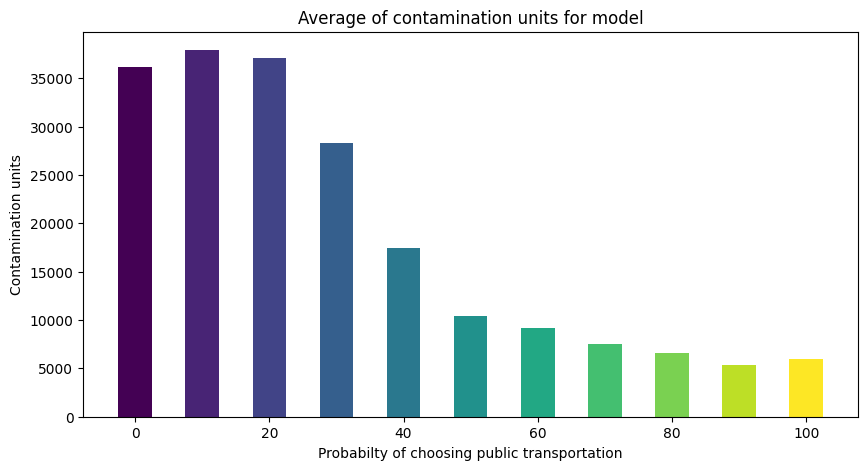

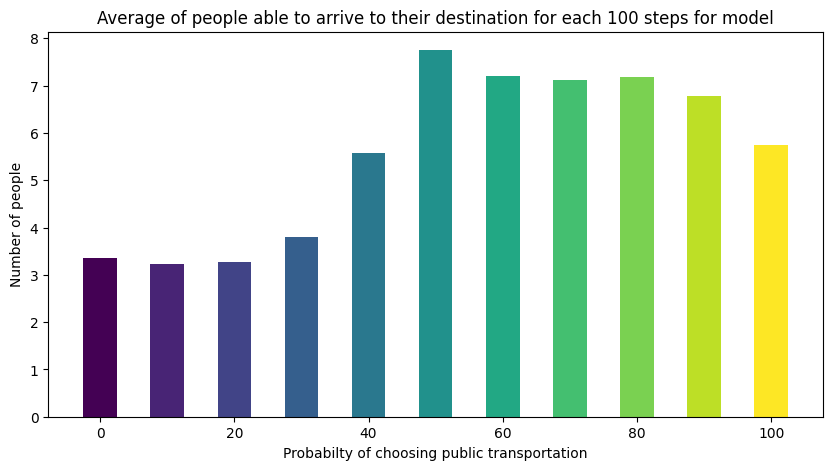

In [12]:
nombres = []
for i in range(0,101,10):
    nombres.append(i)

fig = plt.figure(figsize = (10, 5))
plt.bar(nombres, contaminaciones, color=plt.cm.viridis(np.linspace(0, 1, len(nombres))), 
		width = 5)
plt.xlabel("Probabilty of choosing public transportation")
plt.ylabel("Contamination units")
plt.title("Average of air pollution units for model")
plt.show()

fig = plt.figure(figsize = (10, 5))
plt.bar(nombres, totales, color=plt.cm.viridis(np.linspace(0, 1, len(nombres))), 
		width = 5)
plt.xlabel("Probabilty of choosing public transportation")
plt.ylabel("Number of people")
plt.title("Average of people able to arrive to their destination for each 100 steps for model")
plt.show()

resultados = []
for i in range(len(contaminaciones)):
    resultados.append(totales[i]/contaminaciones[i])
    

fig = plt.figure(figsize = (10, 5))
plt.bar(nombres, resultados, color=plt.cm.viridis(np.linspace(0, 1, len(nombres))), 
		width = 5)
plt.xlabel("Probabilty of choosing public transportation")
plt.ylabel("People/Pollution")
plt.title("Average of people arriving to their destination over total pollution")
plt.show()

In [ ]:
listaAutos = model.iniciadorAutos
listaBuses = model.iniciadorBuses
listaPersonas = model.iniciadorPersonas
listaSemaforos = model.iniciadorSemaforos

pasosPersonas = model.movimientosPersonasPorPaso
pasosBuses = model.movimientosBusesPorPaso
pasosAutos = model.movimientosAutosPorPaso 
pasosSemaforos = model.movimientosSemaforosPorPaso

jsonIniciador = dict(autos = [dict(id=id, x=x, y=y, s=s) for id, x, y, s in listaAutos], buses = [dict(id=id, x=x, y=y, s=s) for id, x, y, s in listaBuses], personas = [dict(id=id, x=x, y=y, s=s) for id, x, y, s in listaPersonas], semaforos = [dict(id=id, x=x, y=y, s=s) for id, x, y, s in listaSemaforos])
jsonMovimientos = dict(pasos = [dict(paso = [dict(autos = [dict(id=id, x=x, y=y, s=s) for id,x,y,s in pasosAutos[i]], buses = [dict(id=id, x=x, y=y, s=s) for id,x,y,s in pasosBuses[i]], personas = [dict(id=id, x=x, y=y, s=s) for id,x,y,s in pasosPersonas[i]], semaforos = [dict(id=id, x=x, y=y, s=s) for id,x,y,s in pasosSemaforos[i]])]) for i in range(len(pasosAutos))])

In [ ]:
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer
import nest_asyncio
nest_asyncio.apply()

def agent_portrayal(agent):

    if isinstance(agent, Camino):
        portrayal = {"Shape": "rect",
                     "Filled": "true",
                     "Layer": 1,
                     "Color": "black",
                     "w": 1,
                     "h": 1}

    elif isinstance(agent, Obstaculo):
        portrayal = {"Shape": "rect",
                     "Filled": "true",
                     "Layer": 4,
                     "Color": "blue",
                     "w": 1,
                     "h": 1}
        
    elif isinstance(agent, Casa):
        portrayal = {"Shape": "rect",
                     "Filled": "true",
                     "Layer": 4,
                     "Color": "brown",
                     "w": 1,
                     "h": 1}
        
    elif isinstance(agent, Estacionamiento):
        portrayal = {"Shape": "rect",
                     "Filled": "true",
                     "Layer": 3,
                     "Color": "yellow",
                     "w": 1,
                     "h": 1}
    
    elif isinstance(agent, Banqueta):
        portrayal = {"Shape": "rect",
                     "Filled": "true",
                     "Layer": 0,
                     "Color": "gray",
                     "w": 1,
                     "h": 1}
        if agent.tipo == 1:
            portrayal["Color"] = "#08fc0c"

    elif isinstance(agent, Semaforo):
        portrayal = {"Shape": "circle",
                     "Filled": "false",
                     "Layer": 4,
                     "Color": agent.color,
                     "r": 0.75}
        
    elif isinstance(agent, Auto):
        portrayal = {"Shape": "circle",
                     "Filled": "false",
                     "Layer": 3,
                     "Color": "orange",
                     "r": 0.5}
                    
    elif isinstance(agent, Autobus):
        portrayal = {"Shape": "circle",
                     "Filled": "false",
                     "Layer": 3,
                     "Color": "blue",
                     "r": 0.6}
        
    elif isinstance(agent, Persona):
        portrayal = {"Shape": "circle",
                     "Filled": "false",
                     "Layer": 2,
                     "Color": "pink",
                     "r": 0.5}
    return portrayal

grid = CanvasGrid(agent_portrayal, 46, 46, 400, 400)

parametros = {"N":50}
server = ModularServer(Ciudad,
                       [grid],
                       "Modelo de Ciudad",
                       parametros)
server.port = 8080
server.launch()

Interface starting at http://127.0.0.1:8080
Socket opened!
{"type":"reset"}
Socket opened!
{"type":"reset"}
{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
{"type":"get_step","step":26}
{"type":"get_step","step":27}
{"type":"get_step","step":28}
{"type":"get_step","step":29}
{"type":"get_step","step":30}
{

import json
# Importar la librería Flask
from flask import Flask

# Crear una instancia de la clase Flask
app = Flask(__name__)

# Definir una ruta para la página principal
@app.route('/')
def home():
    model = Ciudad(10)
    while model.running:
        model.step()
    return "Modelo iniciado correctamente"

@app.route('/iniciadores')
def iniciadores():
    response = app.response_class(
        response=json.dumps(jsonIniciador),
        status=200,
        mimetype='application/json'
    )
    return response

@app.route('/movimientosPorPaso')
def movimientosPorPaso():
    response = app.response_class(
        response=json.dumps(jsonMovimientos),
        status=200,
        mimetype='application/json'
    )
    return response

# Correr el servidor
if __name__ == '__main__':
    app.run(port=5000)